## Introduction
The purpose of this notebook is to illustrate through the usage of an interface how autoencoded embeddings were generated in the dissertation project, clustered and analysed. Due to confidentiality reasons, the dataset used here is not the same as the one used in completion of the dissertation. Furthermore, it is more useful to have a small-sized dataset to speed up the illustration, and so the dataset used here is the Adult  Data Set, obtained form the University of California Irvine Machine Learning Repository [[1]](https://archive.ics.uci.edu/ml/datasets/Adult). It is composed of 48442 instances and 14 features intended to be used to predict whether an individual's income exceeds $50K. For convenience, a description of the features from [[1]]((https://archive.ics.uci.edu/ml/datasets/Adult)) has been copied and provided below. 

<div class="alert alert-block alert-info">
<ul>
<li> <b>age</b>: continuous. 
<li> <b>workclass</b>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
<li> <b>fnlwgt</b>: continuous. 
<li> <b>education</b>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th,  Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
<li> <b>education-num</b>: continuous. 
<li> <b>marital-status</b>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
<li> <b>occupation</b>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
<li> <b>relationship</b>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
<li> <b>race</b>: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
<li> <b>sex</b>: Female, Male. 
<li> <b>capital-gain</b>: continuous. 
<li> <b>capital-loss</b>: continuous. 
<li> <b>hours-per-week</b>: continuous.</li> 
<li> <b>native-country</b>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.</li>
</ul>
</div>


### Importing Packages
In this section the relevant packages and datasets are imported

In [1]:
import pandas as pd
from clusterlib.autoencoder import AutoEncoder
from clusterlib.famd import FAMDRecat
from sklearn.preprocessing import LabelEncoder

### Downloading the Dataset
In this section the dataset is combined, unneeded fields are dropped and categorical features are identified

In [2]:
adult_df = pd.read_csv('notebook_data/adult.csv')
adult_df.head()

,age,workclass,fnlweight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,weekly_hours,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [4]:
adult_df['income'] = adult_df['income'].map({' <=50K': 0, ' >50K': 1})
adult_df.rename(columns = {'income': 'high_income'}, inplace=True)
adult_df.head()

,age,workclass,fnlweight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,weekly_hours,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Generating AutoEncoded Embedding
In this section the autoencoder class used for analysis is created. There are within code descriptions to offer some clarity on the functionality. It should be noted that this code was not written for speed and robustness but for illustration purposes. Furthermore, in this implementation the vector size of categorical attributes is set to the smaller of the fourth root of the number of categories and 50. This is different from the implementation used in the dissertation where it was set to the smaller of half the number of categories and 50.   

The process of generating embeddings is shown for approach A, B and C, defined in Table 3 of the dissertation paper. 

### FAMD Principal Components
Prior to applying approaches A and B, principal components need to be created. In this section a quick exploration of the data is performed and the components are created. We note in the table that all features in the table have less than 50 categories and so recategorization will not be performed. Furthermore, it is noted that only 98 principal components is needed to fully account for the variance in the dataset

We begin by taking a look at the dataftypes of each feature to help with generating a list of numerical and categorical features

In [5]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlweight       32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  weekly_hours    32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  high_income     32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
# creating lists of numerical and categorical features
cat_features = adult_df.select_dtypes(exclude=['int64']).columns.tolist()
num_features = [col for col in adult_df.columns if col not in cat_features]
num_features.remove('high_income')

Next we review the number of unique attributes in each categorical feature to understand if there are features with high cardinality that should be recategorized. It is noted that none of the features have more than 50 unique categories.

Furthermore, a review of the total number of categories and numerical features is not very large. This suggests that there is little need for recategorizing as generating the principal components for this dataset would be fast. Recategorization would therefore not be performed.

In [7]:
# reviewing the size of each category 
adult_df[cat_features].nunique()

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
dtype: int64

In [8]:
# reviewing the total number of categories and numerical features
adult_df[cat_features].nunique().sum() + len(num_features)

108

Here Principal components are generated using the FAMD Recat Class. For simplicity the method for thorughness it is illustrated how the class would be used if recategorization were to be performed. However, the method for aggregation has no impact on the input dataset since none of the categorical features have less than 50 attributes.

In addition, based on the total number of categories and numerical features being 108, 100 principal components is estimated as a reasonable number that should capture all the variance.

In [9]:
# initializing the class
famd_recat = FAMDRecat(adult_df[cat_features + num_features], categorical_columns=cat_features)

# recategorizing categorical features with greater than 50 unique categories
famd_recat.aggregation_function(unique_attr_threshold=50)

# generating 100 principal components
famd_recat.get_principal_components(100)

The end time is 4.529634952545166


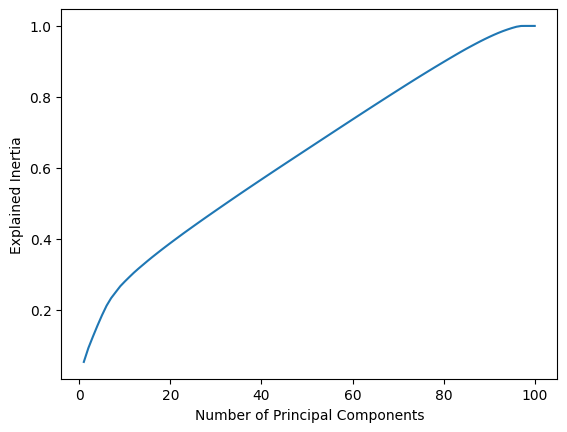

In [10]:
#  a plot of the inertia per added component is shown below
famd_recat.plot_explained_inertia()

In [11]:
# the generated principal components can be obtained from the class attribute famd_pc
famd_recat.famd_pc.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.707696,-1.085980,-0.852887,0.165609,-0.529963,-0.154967,0.158468,-0.007246,-0.142998,0.455687,...,-0.342903,0.079462,0.397356,-0.352798,-0.516158,0.367092,0.035059,0.009346,-8.248836e-17,4.419813e-16
1,0.807993,-0.127523,-1.768084,0.274963,0.377476,-0.252977,-1.616527,-0.706679,-0.275858,0.298867,...,-0.478757,0.356777,-0.232582,0.047535,0.081120,-0.019262,0.017413,-0.003370,-1.493675e-16,4.654015e-16
2,-0.517331,0.255015,0.265049,0.049193,-0.082959,-0.188252,0.433398,-0.174416,-0.432393,0.158299,...,-0.016189,0.083827,0.094976,0.389505,-0.128930,0.080945,-0.003899,0.000497,-5.635365e-17,6.487894e-17
3,-0.541368,1.437521,0.381608,0.150076,0.336038,-0.100778,-0.424869,-0.367525,0.026724,-0.457815,...,-0.316710,0.304451,0.143531,-0.041681,0.168699,-0.291578,-0.004823,-0.000877,4.043143e-16,-1.089801e-17
4,0.281091,-1.303123,0.616566,0.155965,1.292839,-0.853666,0.235044,-0.403869,0.728259,0.022731,...,0.194354,0.120790,0.084495,0.388152,0.467930,0.542772,-0.047221,-0.014935,-8.309778e-16,1.129694e-16


### Approach A: FAMD to FAMD
As explained in the paper, this approach represents categorical features using FAMD principal components. 

In [12]:
approach_a = AutoEncoder(
    famd_recat.famd_pc.iloc[:, :98],
    categorical_columns=[],
    scale=False,
    learned_embedding=False
)

approach_a.build_autoencoder_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 98)]              0         
                                                                 
 dense (Dense)               (None, 500)               49500     
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 2000)              1002000   
                                                                 
 autencoded_embedding (Dense  (None, 2)                4002      
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 2000)              6000      
                                                           

Epoch 1/50


2022-09-24 11:50:53.858217: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


127/128 [============================>.] - ETA: 0s - loss: 0.2248 - mae: 0.2731
Epoch 1: loss improved from inf to 0.22461, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 20ms/step - loss: 0.2246 - mae: 0.2730
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.2009 - mae: 0.2543
Epoch 2: loss improved from 0.22461 to 0.20085, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 21ms/step - loss: 0.2008 - mae: 0.2543
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.1875 - mae: 0.2444
Epoch 3: loss improved from 0.20085 to 0.18756, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 21ms/step - loss: 0.1876 - mae: 0.2444
Epoch 4/50
127/128 [============================>.] - ETA: 0s - loss: 0.1787 - mae: 0.2380
Epoch 4: loss improved from 0.18756 to 0.17873, saving mo

127/128 [============================>.] - ETA: 0s - loss: 0.1014 - mae: 0.1858
Epoch 31: loss improved from 0.10344 to 0.10143, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 22ms/step - loss: 0.1014 - mae: 0.1858
Epoch 32/50
127/128 [============================>.] - ETA: 0s - loss: 0.1008 - mae: 0.1851
Epoch 32: loss improved from 0.10143 to 0.10083, saving model to models/approach_a_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 22ms/step - loss: 0.1008 - mae: 0.1851
Epoch 33/50
128/128 [==============================] - ETA: 0s - loss: 0.1010 - mae: 0.1851
Epoch 33: loss did not improve from 0.10083
128/128 [==============================] - 3s 22ms/step - loss: 0.1010 - mae: 0.1851
Epoch 34/50
126/128 [============================>.] - ETA: 0s - loss: 0.1042 - mae: 0.1881
Epoch 34: loss did not improve from 0.10083
128/128 [==============================] - 3s 22ms/step - loss: 0.1043 - 

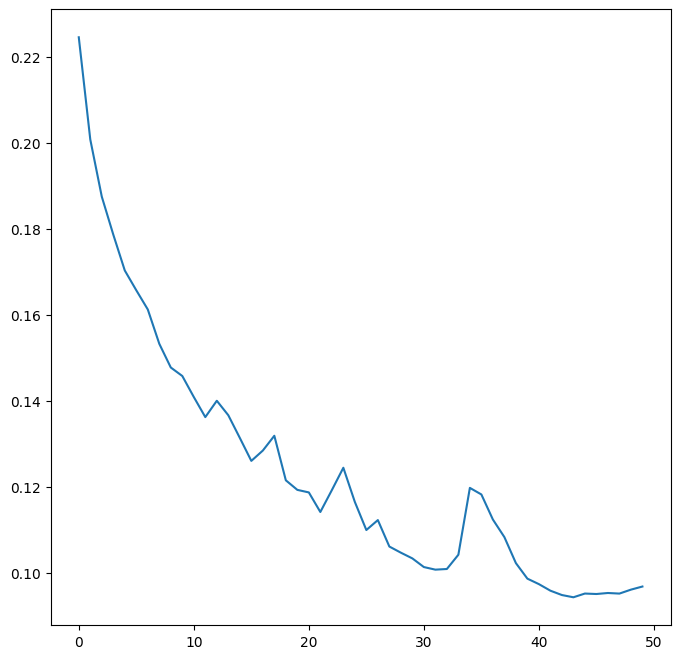

In [13]:
approach_a.fit_model(file_prefix='approach_a_', batch_size=256, epochs=50)

1018/1018 [==============================] - 1s 1ms/step


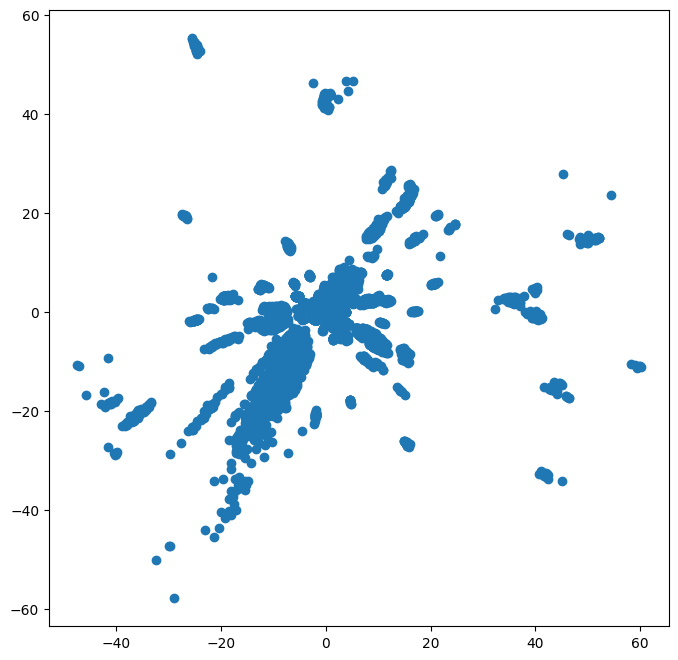

In [14]:
approach_a.extract_autoencoded_embedding()

### HDBSCAN clustering 

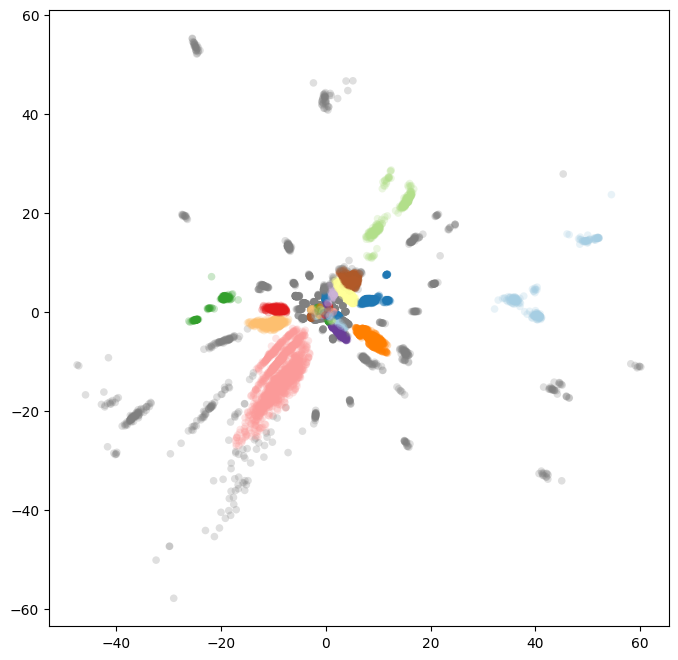

In [15]:
hdbscan_model_a = approach_a.hdbscan_clustering(min_cluster_size=150, min_samples=10)

In [16]:
approach_a.hdbscan_cluster_summary(hdbscan_model_a, adult_df, cat_features, sort_col='high_income')

,high_income,instance_count,age,fnlweight,education_num,capital_gain,capital_loss,weekly_hours,workclass,education,marital_status,occupation,relationship,race,sex,native_country
cluster_assignments,,,,,,,,,,,,,,,,
25,0.000000,448,21.718750,180978.236607,9.729911,93.330357,0.000000,32.223214,?,Some-college,Never-married,?,Own-child,White,Female,United-States
32,0.005725,1048,25.250954,182420.149809,9.000000,125.625954,0.000000,36.496183,Private,HS-grad,Never-married,Other-service,Own-child,White,Male,United-States
33,0.005780,1211,22.947977,191365.389761,10.000000,45.571429,0.000000,30.020644,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Female,United-States
16,0.014245,351,38.475783,206071.943020,9.000000,193.458689,5.421652,38.529915,Private,HS-grad,Separated,Other-service,Unmarried,White,Female,United-States
30,0.016181,309,31.582524,191433.171521,9.000000,203.880259,3.067961,39.365696,Private,HS-grad,Never-married,Other-service,Unmarried,White,Female,United-States
34,0.017964,167,32.209581,204600.449102,10.000000,185.275449,0.000000,38.700599,Private,Some-college,Never-married,Adm-clerical,Unmarried,White,Female,United-States
17,0.021505,372,28.021505,205290.637097,9.346774,163.470430,0.000000,37.529570,Private,HS-grad,Never-married,Adm-clerical,Other-relative,White,Male,United-States
8,0.023026,304,26.993421,194443.983553,7.986842,121.351974,0.000000,32.585526,Private,12th,Never-married,Other-service,Own-child,White,Male,United-States
35,0.023576,1018,31.596267,189429.368369,9.000000,202.184676,0.000000,41.500000,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Male,United-States


In [17]:
approach_a.describe_approach_hdbscan(hdbscan_model_a, adult_df, 'weekly_hours', 'education_num')

{'feature': 'weekly_hours',
 'param_minclustersize': 150,
 'param_minsamples': 10,
 'min_cluster_size': 150,
 'min_mean_cluster_weekly_hours': 30.020644095788604,
 'max_mean_cluster_weekly_hours': 49.79220779220779,
 'percent_potentially_mergeable': 22.786647314949203,
 'multicluster_education_num_count': 16,
 'education_num_unique_attributes': 16,
 'multicluster_education_num_percent': 100.0}

### GMM clustering

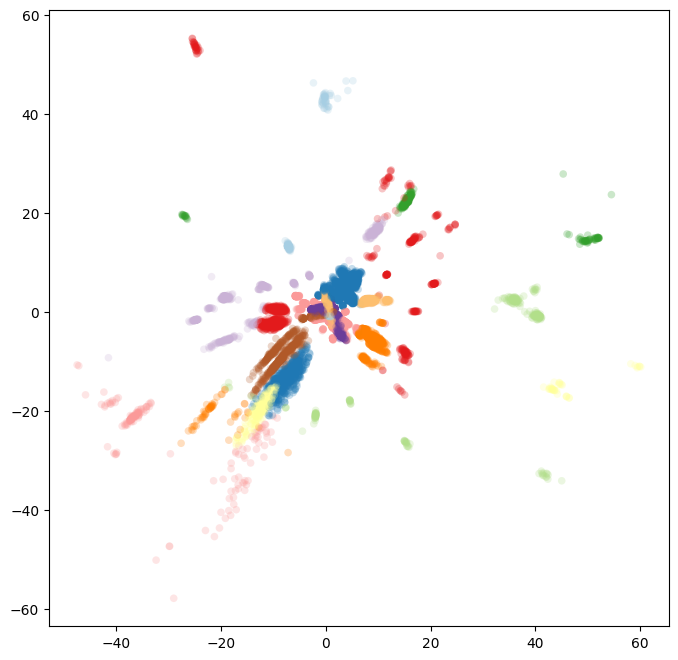

In [18]:
gmm_model_a = approach_a.gmm_clustering(n_components=30)

In [19]:
approach_a.gmm_cluster_summary(gmm_model_a, adult_df, cat_features, sort_col='high_income')

,high_income,instance_count,age,fnlweight,education_num,capital_gain,capital_loss,weekly_hours,workclass,education,marital_status,occupation,relationship,race,sex,native_country
cluster_assignments,,,,,,,,,,,,,,,,
14,0.000000,14,47.785714,174267.500000,9.071429,487.857143,0.000000,32.714286,Without-pay,HS-grad,Married-civ-spouse,Farming-fishing,Own-child,White,Male,United-States
27,0.000000,14,38.714286,204487.785714,10.285714,0.000000,0.000000,41.857143,Private,Some-college,Never-married,Exec-managerial,Not-in-family,White,"[ Female, Male]",Outlying-US(Guam-USVI-etc)
15,0.000000,51,42.764706,235889.372549,1.000000,898.392157,66.490196,36.647059,Private,Preschool,Never-married,Other-service,Not-in-family,White,Male,"[ Mexico, United-States]"
3,0.021583,139,34.769784,279590.906475,3.000000,131.201439,0.000000,40.604317,Private,5th-6th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,Mexico
2,0.035461,141,46.397163,243580.248227,2.000000,109.297872,57.581560,38.269504,Private,1st-4th,Married-civ-spouse,Other-service,Husband,White,Male,Mexico
6,0.046512,473,41.080338,204561.454545,5.002114,153.116279,8.173362,37.862579,Private,9th,Married-civ-spouse,Other-service,Husband,White,Male,United-States
13,0.047259,1058,31.491493,195511.642722,6.999055,220.441399,1.227788,33.806238,Private,11th,Never-married,Other-service,Own-child,White,Male,United-States
25,0.051187,1348,35.870920,195997.594955,6.826409,194.477745,1.525964,35.867953,Private,10th,Never-married,Other-service,Own-child,White,Male,United-States
5,0.064516,31,35.258065,274559.354839,9.354839,59.064516,59.612903,35.387097,Private,HS-grad,Never-married,Other-service,Own-child,White,Male,Peru


In [20]:
approach_a.describe_approach_gmm(gmm_model_a, adult_df, 'weekly_hours', 'education_num')

{'feature': 'weekly_hours',
 'param_components': 30,
 'param_num_init': 10,
 'min_cluster_size': 14,
 'min_mean_cluster_weekly_hours': 32.714285714285715,
 'max_mean_cluster_weekly_hours': 50.03333333333333,
 'percent_potentially_mergeable': 48.275862068965516,
 'multicluster_education_num_count': 15,
 'education_num_unique_attributes': 16,
 'multicluster_education_num_percent': 93.75}

{1: 407359.77379622066,
 2: 291095.2672432141,
 3: 285314.1930294703,
 4: 281182.48752327537,
 5: 262078.75748715532,
 6: 279489.7021797817,
 7: 275838.42025933164,
 8: 275233.41136697395,
 9: 275586.0977232193}

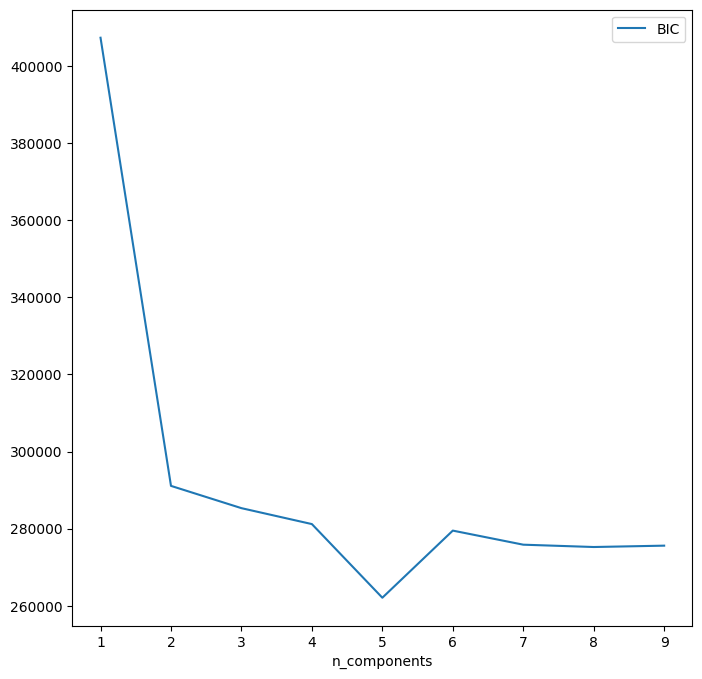

In [21]:
approach_a.gmm_bic_plot(components_list=list(range(1, 10)), n_init=5)

### Approach B: Learned Embeddings to FAMD Principal Components

In [22]:
approach_b = AutoEncoder(
    adult_df[cat_features + num_features],
    output_data=famd_recat.famd_pc.iloc[:, :98],
    categorical_columns=cat_features,
)
approach_b.build_autoencoder_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

__________________________________________________________________________________________________


Epoch 1/100
126/128 [============================>.] - ETA: 0s - loss: 0.2361 - mae: 0.2812
Epoch 1: loss improved from inf to 0.23593, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 22ms/step - loss: 0.2359 - mae: 0.2812
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.2166 - mae: 0.2682
Epoch 2: loss improved from 0.23593 to 0.21658, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.2166 - mae: 0.2682
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.2099 - mae: 0.2627
Epoch 3: loss improved from 0.21658 to 0.20989, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.2099 - mae: 0.2627
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.2048 - mae: 0.2578
Epoch 4: loss improved from 0.20989 to 0.2

128/128 [==============================] - 3s 24ms/step - loss: 0.1733 - mae: 0.2228
Epoch 30/100
126/128 [============================>.] - ETA: 0s - loss: 0.1731 - mae: 0.2224
Epoch 30: loss improved from 0.17330 to 0.17290, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.1729 - mae: 0.2223
Epoch 31/100
127/128 [============================>.] - ETA: 0s - loss: 0.1728 - mae: 0.2224
Epoch 31: loss did not improve from 0.17290
128/128 [==============================] - 3s 23ms/step - loss: 0.1730 - mae: 0.2225
Epoch 32/100
126/128 [============================>.] - ETA: 0s - loss: 0.1727 - mae: 0.2222
Epoch 32: loss improved from 0.17290 to 0.17281, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.1728 - mae: 0.2222
Epoch 33/100
126/128 [============================>.] - ETA: 0s - loss: 0.1724 - mae: 0.2219
Epoch 33: loss i

128/128 [==============================] - 3s 24ms/step - loss: 0.1691 - mae: 0.2182
Epoch 63/100
128/128 [==============================] - ETA: 0s - loss: 0.1689 - mae: 0.2180
Epoch 63: loss improved from 0.16910 to 0.16887, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.1689 - mae: 0.2180
Epoch 64/100
128/128 [==============================] - ETA: 0s - loss: 0.1688 - mae: 0.2179
Epoch 64: loss improved from 0.16887 to 0.16882, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.1688 - mae: 0.2179
Epoch 65/100
127/128 [============================>.] - ETA: 0s - loss: 0.1683 - mae: 0.2176
Epoch 65: loss improved from 0.16882 to 0.16868, saving model to models/approach_b_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.1687 - mae: 0.2177
Epoch 66/100
127/128 [=================

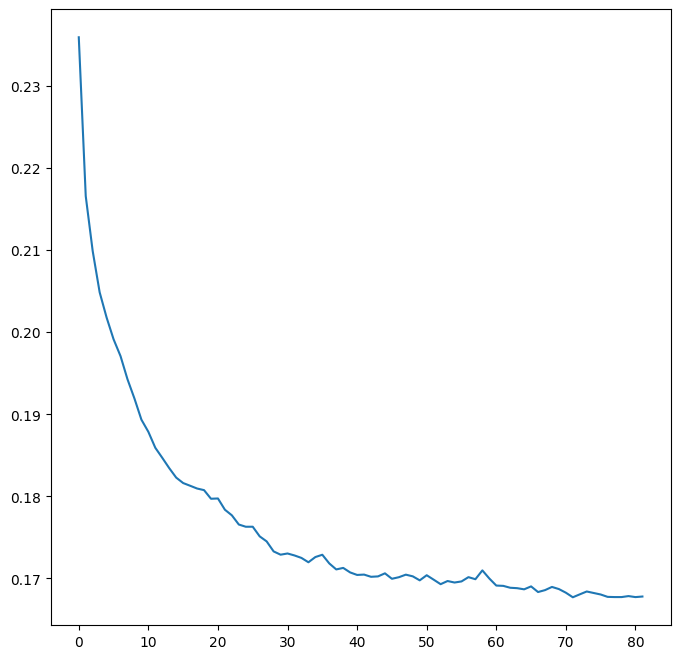

In [23]:
approach_b.fit_model(file_prefix='approach_b_')

1018/1018 [==============================] - 1s 1ms/step


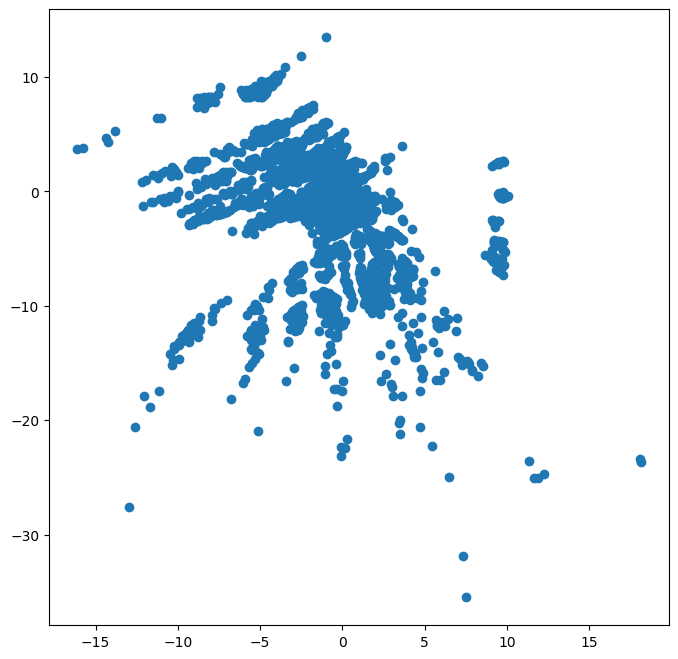

In [24]:
approach_b.extract_autoencoded_embedding()

### Approach C: Learned Embeddings to Nominal Encodings

In [25]:
approach_c = AutoEncoder(
    adult_df[cat_features + num_features],
    categorical_columns=cat_features
)
approach_c.build_autoencoder_model()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                           

__________________________________________________________________________________________________


Epoch 1/100
126/128 [============================>.] - ETA: 0s - loss: 14.3769 - mae: 1.7647
Epoch 1: loss improved from inf to 14.28481, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 4s 23ms/step - loss: 14.2848 - mae: 1.7596
Epoch 2/100
126/128 [============================>.] - ETA: 0s - loss: 3.3789 - mae: 1.1308
Epoch 2: loss improved from 14.28481 to 3.36828, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 3.3683 - mae: 1.1292
Epoch 3/100
126/128 [============================>.] - ETA: 0s - loss: 2.0109 - mae: 0.9159
Epoch 3: loss improved from 3.36828 to 2.00866, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 2.0087 - mae: 0.9154
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 1.4982 - mae: 0.8202
Epoch 4: loss improved from 2.00866 to

Epoch 30/100
126/128 [============================>.] - ETA: 0s - loss: 0.7711 - mae: 0.5496
Epoch 30: loss improved from 0.79174 to 0.77058, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.7706 - mae: 0.5495
Epoch 31/100
128/128 [==============================] - ETA: 0s - loss: 0.7637 - mae: 0.5511
Epoch 31: loss improved from 0.77058 to 0.76365, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.7637 - mae: 0.5511
Epoch 32/100
128/128 [==============================] - ETA: 0s - loss: 0.7569 - mae: 0.5474
Epoch 32: loss improved from 0.76365 to 0.75689, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.7569 - mae: 0.5474
Epoch 33/100
127/128 [============================>.] - ETA: 0s - loss: 0.7544 - mae: 0.5522
Epoch 33: loss improved from 0.

128/128 [==============================] - ETA: 0s - loss: 0.5208 - mae: 0.4504
Epoch 59: loss improved from 0.52942 to 0.52078, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.5208 - mae: 0.4504
Epoch 60/100
126/128 [============================>.] - ETA: 0s - loss: 0.5248 - mae: 0.4545
Epoch 60: loss did not improve from 0.52078
128/128 [==============================] - 3s 24ms/step - loss: 0.5250 - mae: 0.4543
Epoch 61/100
128/128 [==============================] - ETA: 0s - loss: 0.5224 - mae: 0.4550
Epoch 61: loss did not improve from 0.52078
128/128 [==============================] - 3s 24ms/step - loss: 0.5224 - mae: 0.4550
Epoch 62/100
126/128 [============================>.] - ETA: 0s - loss: 0.5059 - mae: 0.4397
Epoch 62: loss improved from 0.52078 to 0.50552, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.5055

127/128 [============================>.] - ETA: 0s - loss: 0.4533 - mae: 0.4141
Epoch 91: loss improved from 0.45790 to 0.45317, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.4532 - mae: 0.4141
Epoch 92/100
127/128 [============================>.] - ETA: 0s - loss: 0.4503 - mae: 0.4141
Epoch 92: loss improved from 0.45317 to 0.45016, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.4502 - mae: 0.4141
Epoch 93/100
126/128 [============================>.] - ETA: 0s - loss: 0.4503 - mae: 0.4140
Epoch 93: loss improved from 0.45016 to 0.45004, saving model to models/approach_c_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.4500 - mae: 0.4139
Epoch 94/100
126/128 [============================>.] - ETA: 0s - loss: 0.4498 - mae: 0.4127
Epoch 94: loss improved from 0.45004 to 0.44

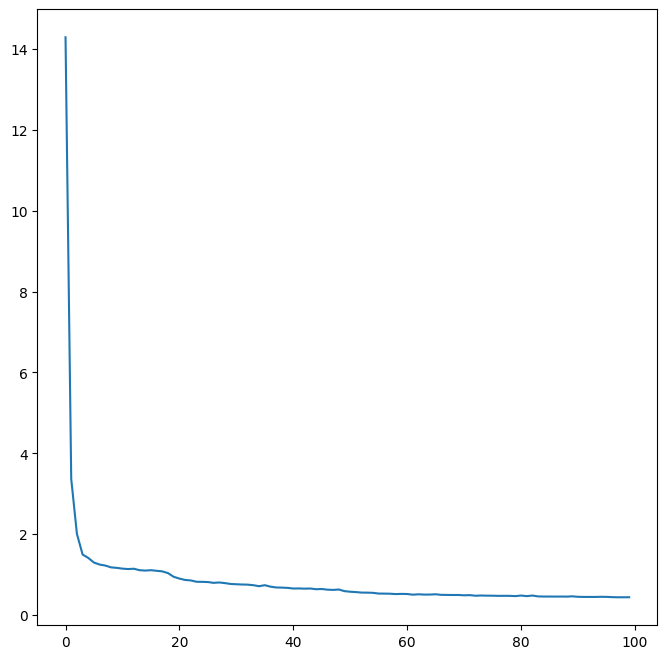

In [26]:
approach_c.fit_model(file_prefix='approach_c_')

1018/1018 [==============================] - 1s 1ms/step


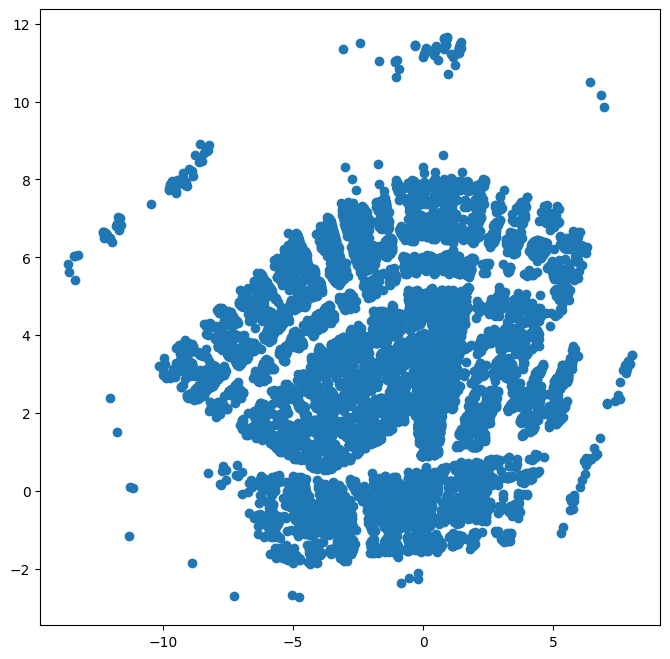

In [27]:
approach_c.extract_autoencoded_embedding()

### Approach D: Learned Embeddings to Nominal Encoding of the Occupation Feature


In [28]:
output_d = adult_df[cat_features + num_features].copy()

# nominal encoding the occupation column
occupation_col = LabelEncoder().fit_transform(output_d['occupation'])

for col in output_d.columns:
    output_d[col] = occupation_col

In [29]:
approach_d = AutoEncoder(
    adult_df[cat_features + num_features],
    output_data=output_d,
    categorical_columns=cat_features,
)
approach_d.build_autoencoder_model()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                           

__________________________________________________________________________________________________


Epoch 1/100
127/128 [============================>.] - ETA: 0s - loss: 12.0094 - mae: 2.3743
Epoch 1: loss improved from inf to 11.99205, saving model to models/approach_d_dim2embedding_relu_batch256.h5
128/128 [==============================] - 4s 22ms/step - loss: 11.9920 - mae: 2.3713
Epoch 2/100
127/128 [============================>.] - ETA: 0s - loss: 0.0693 - mae: 0.1670
Epoch 2: loss improved from 11.99205 to 0.06928, saving model to models/approach_d_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 23ms/step - loss: 0.0693 - mae: 0.1669
Epoch 3/100
127/128 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.0955
Epoch 3: loss improved from 0.06928 to 0.02132, saving model to models/approach_d_dim2embedding_relu_batch256.h5
128/128 [==============================] - 3s 24ms/step - loss: 0.0213 - mae: 0.0955
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.0216 - mae: 0.0937
Epoch 4: loss did not improve from 0.0

128/128 [==============================] - 3s 24ms/step - loss: 9.5266e-04 - mae: 0.0207
Epoch 36/100
127/128 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0287
Epoch 36: loss did not improve from 0.00095
128/128 [==============================] - 3s 23ms/step - loss: 0.0020 - mae: 0.0288
Epoch 37/100
128/128 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0648
Epoch 37: loss did not improve from 0.00095
128/128 [==============================] - 3s 24ms/step - loss: 0.0105 - mae: 0.0648
Epoch 38/100
127/128 [============================>.] - ETA: 0s - loss: 0.0225 - mae: 0.0882
Epoch 38: loss did not improve from 0.00095
128/128 [==============================] - 3s 23ms/step - loss: 0.0224 - mae: 0.0881
Epoch 39/100
128/128 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0277
Epoch 39: loss did not improve from 0.00095
128/128 [==============================] - 3s 23ms/step - loss: 0.0017 - mae: 0.0277
Epoch 40/100
126/128 [=

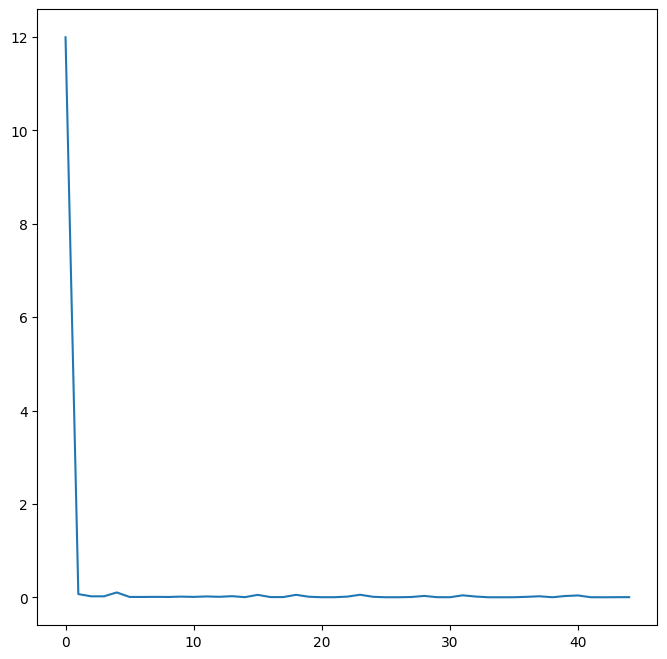

In [30]:
approach_d.fit_model(file_prefix='approach_d_')

1018/1018 [==============================] - 1s 1ms/step


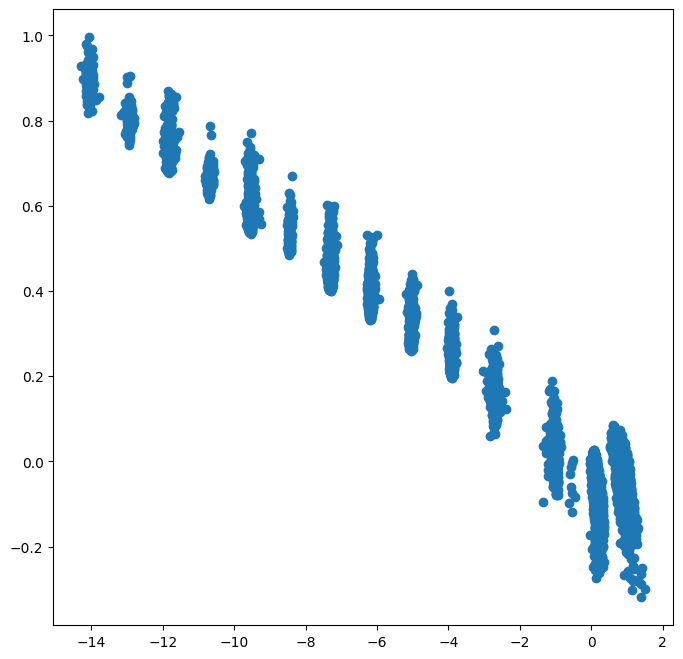

In [31]:
approach_d.extract_autoencoded_embedding()

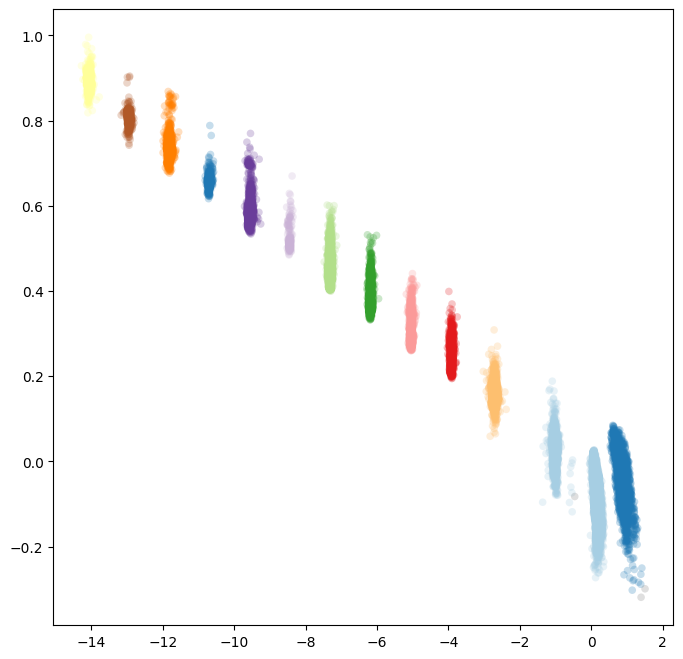

In [32]:
hdbscan_model_d = approach_d.hdbscan_clustering(min_cluster_size=100)

In [33]:
approach_d.hdbscan_cluster_summary(
    hdbscan_model=hdbscan_model_d, data=adult_df, cat_cols=cat_features, sort_col='high_income')

,high_income,instance_count,age,fnlweight,education_num,capital_gain,capital_loss,weekly_hours,workclass,education,marital_status,occupation,relationship,race,sex,native_country
cluster_assignments,,,,,,,,,,,,,,,,
8,0.006711,149,41.724832,201107.523490,7.362416,279.852349,21.449664,32.885906,Private,HS-grad,Never-married,Priv-house-serv,Not-in-family,White,Female,United-States
2,0.041578,3295,34.949621,188608.452200,8.779666,191.301669,38.250683,34.701669,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Female,United-States
4,0.062774,1370,32.165693,204391.006569,8.510219,257.572993,45.635766,37.947445,Private,HS-grad,Never-married,Handlers-cleaners,Husband,White,Male,United-States
13,0.103748,1841,40.842477,188720.700706,9.253123,605.147746,55.863118,31.897338,?,HS-grad,Never-married,?,Own-child,White,Male,United-States
5,0.115694,994,41.211268,170190.176056,8.608652,589.726358,63.075453,46.989940,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
3,0.124875,2002,37.715285,195040.877622,8.487512,328.689311,61.706294,40.755744,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
12,0.134483,3770,36.964456,192043.396286,10.113528,495.954907,60.794430,37.558355,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Female,United-States
10,0.200376,1597,40.197871,190366.355041,8.767063,490.323732,81.480902,44.656230,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
0,0.226199,4107,39.010470,192146.565376,9.111760,648.247626,88.292915,42.301193,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States


## References 
1. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.